In [ ]:
# default_exp single_LW_walker

In [52]:
#export
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdmC
from joblib import Parallel, delayed

In [1]:
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

# Lévy Walks

In [287]:
#export
def lw_step(alpha, steps = 1):
    return (1 - np.random.rand(steps))**(-1/alpha)

def lw_trajs(N = 1, T = 100, alpha = 1, L = None, BC = 'reflectant'):
    
    pos = np.zeros((N, T, 2))
    
    if L is None:
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = (N, T))
        steps = (1 - np.random.rand(N, T))**(-1/alpha)
        pos[:, :, 0], pos[:, :, 1] = [steps*np.cos(angles), steps*np.sin(angles)] 
   
        return np.cumsum(pos, axis = 1)

    else:
        
        pos = np.zeros((N, T, 2))
        pos[:, 0, :] = np.random.rand(N, 2)*L

        for t in tqdm(range(1, T)):

            angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
            steps = (1 - np.random.rand(N))**(-1/alpha)
            pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
            pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]


        if BC == 'periodic':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0]              
        
            
        
        return pos




In [288]:
alpha = 1; L = 10000
N = int(1e2); T = int(1e4)

trajs = lw_trajs(N = N, T = T, alpha = alpha, L = L, BC = 'periodic')

if L is not None:
#     trajsm  = (trajs.reshape(T, N, 2) - trajs[:, 0, :]).reshape(N, T, 2)
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()


msd = np.mean(trajsm**2, axis= 0)
# msd = np.mean(msd, axis = 1)

  0%|          | 0/9999 [00:00<?, ?it/s]

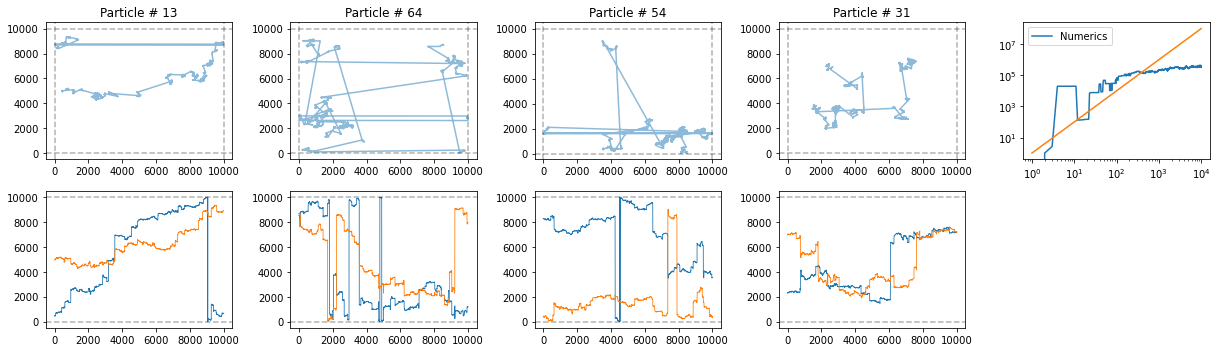

In [289]:
fig, axs = plt.subplots(2, 5, figsize = (17, 5), tight_layout = True)

for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 0.5)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()


# Introducing Targets

In [3]:
#export
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson


def get_distance(x):
    M = np.reshape(np.repeat(x[ :, :], x.shape[0], axis = 0), (x.shape[0], x.shape[0], 2))
    Mtrans = M.transpose(1,0,2)
    distance = np.sqrt(np.square(M[:,:, 0]-Mtrans[:,:, 0])
                     + np.square(M[:,:, 1]-Mtrans[:,:, 1]))  
    return distance

def isBetween(a, b, c, epsilon = 0):
    crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
    if dotproduct < 0:
        return False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    if dotproduct > squaredlengthba:
        return False

    return True

def isBetween_ab_Vec(a, b, c, epsilon = 0):
    mask = np.array([True]*a.shape[0])
    
    crossproduct = (c[1] - a[:,1]) * (b[:,0] - a[:,0]) - (c[0] - a[:, 0]) * (b[:, 1] - a[:, 1])
    mask[np.argwhere(abs(crossproduct) > epsilon)] = False    

    dotproduct = (c[0] - a[:, 0]) * (b[:, 0] - a[:, 0]) + (c[1] - a[:, 1])*(b[:, 1] - a[:, 1])
    mask[np.argwhere(dotproduct < 0)] = False

    squaredlengthba = (b[:, 0] - a[:, 0])*(b[:, 0] - a[:, 0]) + (b[:, 1] - a[:, 1])*(b[:, 1] - a[:, 1])
    mask[np.argwhere(dotproduct > squaredlengthba)] = False
    
    return mask

def isBetween_c_Vec(a, b, c, epsilon = 0):
    mask = np.array([True]*c.shape[0])
    
    crossproduct = (c[:,1] - a[1]) * (b[0] - a[0]) - (c[:,0] - a[0]) * (b[1] - a[1])
    mask[np.argwhere(abs(crossproduct) > epsilon)] = False    

    dotproduct = (c[:, 0] - a[0]) * (b[0] - a[0]) + (c[:, 1] - a[1])*(b[1] - a[1])
    mask[np.argwhere(dotproduct < 0)] = False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    mask[np.argwhere(dotproduct > squaredlengthba)] = False
    
    return mask

In [42]:
#export
def LW_search(Nt = 100, at = 1, lc = 1,
              rho = 1e-3,
              L= 1000,   
              N = 1000, T = 1000,
              alpha = 0.5,
              BC = 'periodic'):

    diag = np.sqrt(2*L**2)

    target_positions = np.random.rand(Nt, 2)*L

    pos = np.zeros((N, T, 2))
    pos[:, 0, :] = np.random.rand(N, 2)*L

    encounter = np.zeros((N, T)).astype(bool)


    counter_target = 0
    for t in tqdmC(range(1, T)):

        angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
        steps = (1 - np.random.rand(N))**(-1/alpha)

        steps[steps > diag] = diag
        pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
        pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        masked = np.array([False]*N)
        for idxT, pT in enumerate(target_positions):

            mask = isBetween_ab_Vec(pos[:, t, :], pos[:, t-1, :], pT, epsilon = at)

            masked += np.array(mask)

            pos[mask == True, t, :] = pT

        encounter[:, t] = masked
        sum_m = np.sum(masked)

        if sum_m > 0:
            angle = np.random.uniform(low = 0, high = 2*np.pi, size = sum_m)
            pos[masked == True, t, 0] += lc*np.cos(angle)
            pos[masked == True, t, 1] += lc*np.sin(angle)

        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]
        if BC == 'periodic':      
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0] 
                
    return encounter
                

In [27]:
Nt = 1000
N = 10000; T = int(1e4)
L = 450 
at = 0.5

alphas = np.linspace(0.2, 2, num = 18)
pos_alpha = np.zeros((len(alphas), N, T, 2))
encounter_alpha = np.zeros((len(alphas), N, T, 2))


info = Parallel(n_jobs=18)(delayed (LW_search) (Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at)
                                    for alpha in alphas)
    

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

### Results

In [29]:
enc = np.zeros(len(alphas))
mean = np.zeros(len(alphas))
std = np.zeros(len(alphas))



for idx, ia in enumerate(info):
    enc[idx] = np.sum(ia[1])
    totalN = np.sum(ia[1], axis = 1)
    mean[idx] = np.mean(totalN)
    std[idx] = np.std(totalN)

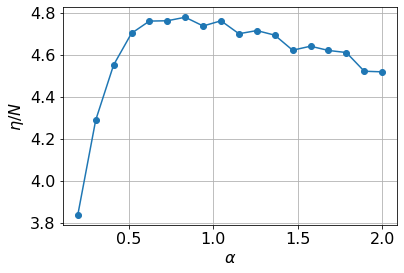

In [57]:
plt.plot(alphas, mean, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta / N$')
plt.grid('on')

### Some trajectory examples

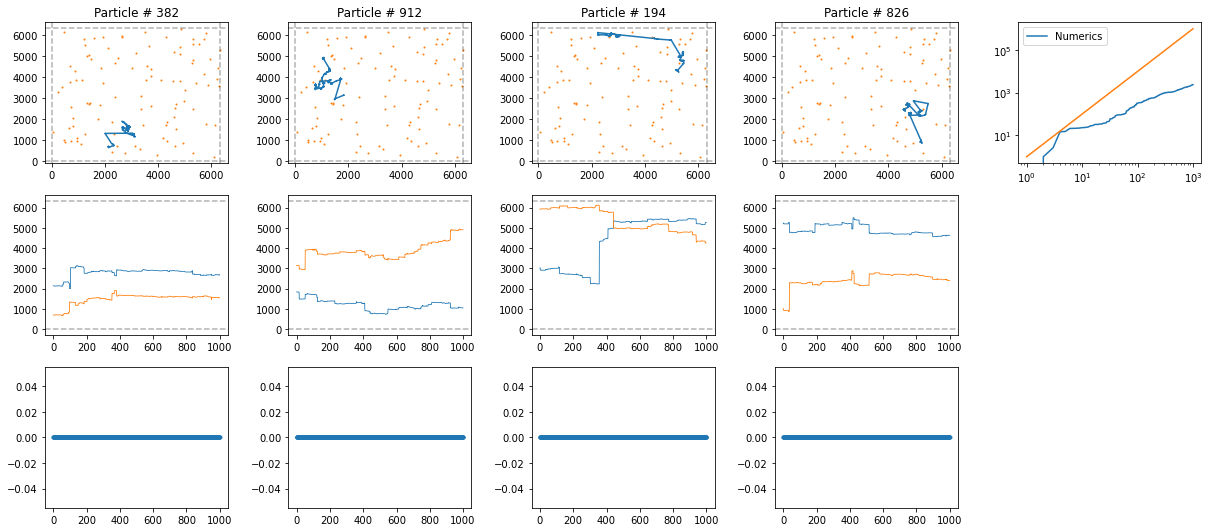

In [472]:
fig, axs = plt.subplots(3, 5, figsize = (17, 7.5), tight_layout = True)

trajs = pos
if L is not None:
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()
msd = np.mean(trajsm**2, axis= 0)



for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 1)
    ax[0].scatter(target_positions[:, 0], target_positions[:, 1], c = 'C1', s = 1)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    
    ax[2].plot(encounter[part, :], '.')

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()
axs[2, -1].set_axis_off()



# NBDEV Export

In [2]:
from nbdev.export import notebook2script
notebook2script()

Converted single_LW_walker.ipynb.
Converted single_RL_walker.ipynb.
